<a href="https://colab.research.google.com/github/wigglytuff-tu/CS6910_Assignment_2/blob/main/PartA/PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [ ]:
!wandb login

In [4]:
import torch
import numpy as np
import torchvision
import os
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import copy
from tqdm.notebook import tqdm
import wandb
from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms.transforms import RandomRotation

In [5]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = "cpu"

In [6]:
# Function to calculate output dimension of convolution layers
def OutShape(H,W,conv,pool=2):
  kernel_size=conv.kernel_size
  stride=conv.stride
  padding=conv.padding
  dilation=conv.dilation
  # Formula taken as it is from torch docs
  H_out=np.floor((H+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
  W_out=np.floor((W+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
  if pool:
    H_out/=pool
    W_out/=pool
  return int(H_out),int(W_out)

In [7]:
class conv_net(nn.Module):
  def __init__(self, params): #num_filters, filter_size, activation_functions,dense_neurons,BatchNorm
    super(conv_net,self).__init__()
    c_in, h_in, w_in = params["input_shape"]
    num_filters = params["num_filters"]
    filter_size = params["filter_size"]
    self.act_function = params["activation_functions"]
    dense_neurons = params["dense_neurons"]
    self.dropout = params["dropout"]
    self.bn = params["BatchNorm"]
 

    ####Conv layers
    layers = []
    for i in range(5):
      if i==0:
        layers.append(nn.Conv2d(c_in, num_filters[0], kernel_size=filter_size[0]))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(self.act_function)
        h,w = OutShape(h_in, w_in, layers[i])
      else:
        layers.append(nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=filter_size[i]))
        h,w = OutShape(h, w, layers[-1])
        if self.bn:
          layers.append(nn.BatchNorm2d(num_filters[i]))

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(self.act_function)

    self.conv = nn.Sequential(*layers)
    self.num_flatten = h*w*num_filters[4]
    self.fc1 = nn.Linear(self.num_flatten, dense_neurons)
    torch.nn.init.xavier_uniform(self.fc1.weight)
    if self.bn:
      self.fc1_bn = nn.BatchNorm2d(dense_neurons)
    self.fc2 = nn.Linear(dense_neurons, 10)
    torch.nn.init.xavier_uniform(self.fc1.weight)

  def forward(self,x):
    x = self.conv(x)
    #Flatening the layers
    x = x.view(-1, self.num_flatten)
    
    x = self.act_function(self.fc1(x))
    x = F.dropout(x, self.dropout, training= self.training)
    x = self.fc2(x)
    x = F.log_softmax(x, dim=1)
    return x   

In [8]:
def dataloader(path_to_dir,augmentation,batch_size,image_size):

  train_dir = os.path.join(path_to_dir, "train")
  test_dir = os.path.join(path_to_dir, "val")  

  test_transforms = transforms.Compose([
  transforms.Resize((image_size,image_size)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

  # DATA-Augmentations
  if augmentation:
    train_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.RandomRotation((-20,20)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
  else:
    train_transforms = test_transforms  

  data = datasets.ImageFolder(train_dir, train_transforms)
  test_data = datasets.ImageFolder(test_dir, test_transforms)

  n_val = int(np.floor(0.2 * len(data)))
  n_train = len(data) - n_val
  train_ds, val_ds = random_split(data, [n_train, n_val])

  print("Number of datapoints in train: ", len(train_ds))
  print("Number of datapoints in val: ", len(val_ds))
  print("Number of datapoints in test: ", len(test_data))

  train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
  val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
  test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

  return train_dl,val_dl,test_dl


In [9]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [16]:
def training(model, train_params):
  
  epochs = train_params["num_epochs"]
  train_dl = train_params["train_dl"]
  loss_func = train_params["loss_func"]
  opt = train_params["opt"]
  val_dl = train_params["val_dl"]
  schedular = train_params['schedular']

  train_loss_hist = []
  valid_loss_hist = []
  train_acc_hist = []
  valid_acc_hist = []
  valid_loss_min = np.Inf

  for i in range(epochs):
      
      train_loss = 0.0
      valid_loss = 0.0
      train_acc = 0.0
      valid_acc = 0.0 
      
      
      model.train()
      
      for images,labels in tqdm(train_dl):
          
          images = images.to(device)
          labels = labels.to(device)
          
          ps = model(images)
          loss = loss_func(ps,labels)
          
          opt.zero_grad()
          loss.backward()
          opt.step()
          
          train_acc += accuracy(ps,labels)
          train_loss += loss.item()
          
      avg_train_acc = train_acc / len(train_dl)
      train_acc_hist.append(avg_train_acc)
      avg_train_loss = train_loss / len(train_dl)
      train_loss_hist.append(avg_train_loss)
          
      model.eval()
      with torch.no_grad():
          
          for images,labels in tqdm(val_dl):
              
              images = images.to(device)
              labels = labels.to(device)
              
              ps = model(images)
              loss = loss_func(ps,labels)
              
              valid_acc += accuracy(ps,labels)
              valid_loss += loss.item()
              
              
          avg_valid_acc = valid_acc / len(val_dl)
          valid_acc_hist.append(avg_valid_acc)
          avg_valid_loss = valid_loss / len(val_dl)
          valid_loss_hist.append(avg_valid_loss)
          
          schedular.step(avg_valid_loss)
          
          if avg_valid_loss <= valid_loss_min:
              print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
              torch.save({
                  'epoch' : i,
                  'model_state_dict' : model.state_dict(),
                  'optimizer_state_dict' : opt.state_dict(),
                  'valid_loss_min' : avg_valid_loss
              },'model.pth')
              
              valid_loss_min = avg_valid_loss
              
      print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
      print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))

      wandb.log({"epoch":i,"Train_loss":avg_train_loss,"Train_acc":avg_train_acc,"val_loss":avg_valid_loss,"val_Accuracy":avg_valid_acc})

In [ ]:
sweep_configuration = {'method'    : "bayes",  #Other available--> grid, bayes
                       'metric'    : {'name': 'val_Accuracy','goal':'maximize'},
                       'parameters': {'num_filters':{'values':[[64,64,64,64,64],[512,256,128,64,32], 
                                                               [32,64,128,256,512]]}, 
                                      'filter_size': {'values': [[3,3,3,3,3], [9,7,5,3,3]]},
                                      'dropout': {'values': [0.0,0.1,0.3]},
                                      'dense_neurons': {'values':[256,512]},
                                      'BatchNorm': {'values':[True]},
                                      'Augment':{'values':[False]},
                                      'act_func':{'values':['relu','leakyrelu','mish','silu']}}}
     

In [ ]:
def sweep_train():
  wandb.init(project="CS6910-Assignment-2", entity="purvam",config=sweep_configuration, magic=True)

  config=wandb.config
  num_filters=config.num_filters
  filter_size=config.filter_size 
  dropout=config.dropout
  dense_neurons=config.dense_neurons 
  BatchNorm=config.BatchNorm 
  Augment = config.Augment
  act_func = config.act_func

  if act_func == 'relu':
    activation = nn.ReLU()
  elif act_func == 'leakyrelu':
    activation = nn.LeakyReLU()
  elif act_func == 'mish':
    activation = nn.Mish()
  elif act_func == 'silu':
    activation = nn.SiLU()
  

  train_dl,val_dl,test_dl = dataloader('/content/drive/MyDrive/CS6910/inaturalist_12K',Augment,64,128)

  wandb.run.name = "num_filter_{}_filter_size_{}_dropout_{}_dense_n_{}_batchnorm_{}_augment_{}_act_{}".format(num_filters,
                                                                                    filter_size,                                                                           
                                                                                    dropout,
                                                                                    dense_neurons,
                                                                                    str(BatchNorm),
                                                                                    str(Augment),
                                                                                    act_func)
  
  params = {"input_shape": (3,128,128),
          "num_filters": num_filters,
          "filter_size":filter_size,
          "activation_functions": activation,
          "dense_neurons": dense_neurons,
          "num_output":10,
          "dropout": dropout,
          "BatchNorm": BatchNorm          
          }
 

  model = conv_net(params)  
  opt = optim.Adam(model.parameters(), lr=1e-3)
  loss_func = nn.CrossEntropyLoss()
  schedular = optim.lr_scheduler.ReduceLROnPlateau(opt,factor = 0.5,patience = 3)
  model.to(device)
  
  train_params = {"num_epochs": 10,
                "loss_func": loss_func,
                "train_dl":train_dl ,
                "val_dl":val_dl, 
                "test_dl": test_dl,
                "path2weights": "./",
                "opt": opt,
                "schedular":schedular
               }

  training(model,train_params )

In [ ]:
sweep_id = wandb.sweep(sweep_configuration,project='CS6910-Assignment-2')
wandb.agent(sweep_id,function=sweep_train,project='CS6910-Assignment-2')

## Testing Best Model

In [ ]:
params = {"input_shape": (3,128,128),
          "num_filters": [32,64,128,256,512],
          "filter_size":[3,3,3,3,3],
          "activation_functions": nn.Mish(),
          "dense_neurons": 512,
          "num_output":10,
          "dropout": 0.1,
          "BatchNorm": True          
          }

model = conv_net(params)
model.to(device);

In [24]:
train_dl,val_dl,test_dl = dataloader('/content/drive/MyDrive/CS6910/inaturalist_12K',False,64,128)

Number of datapoints in train:  8000
Number of datapoints in val:  1999
Number of datapoints in test:  2000


In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
schedular = optim.lr_scheduler.ReduceLROnPlateau(opt,factor = 0.5,patience = 3)
model.to(device)

train_params = {"num_epochs": 30,
              "loss_func": loss_func,
              "train_dl":train_dl ,
              "val_dl":val_dl, 
              "test_dl": test_dl,
              "path2weights": "./",
              "opt": opt,
              "schedular":schedular
              }
model.cuda()

In [28]:
test_acc = 0.0
test_loss = 0.0
with torch.no_grad():

  model.eval()
  for images,labels in tqdm(test_dl):
      
      images = images.to(device)
      labels = labels.to(device)
      
      ps = model(images)
      loss = loss_func(ps,labels)
      
      test_acc += accuracy(ps,labels)
      test_loss += loss.item()
      
      
  avg_test_acc = test_acc / len(test_dl)
  avg_test_loss = test_loss / len(test_dl)

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(avg_test_loss,avg_test_acc))

  0%|          | 0/32 [00:00<?, ?it/s]

Test Loss : 2.388373 Test Acc : 0.406738


wandb: Currently logged in as: purvam. Use `wandb login --relogin` to force relogin





True Label :Amphibia



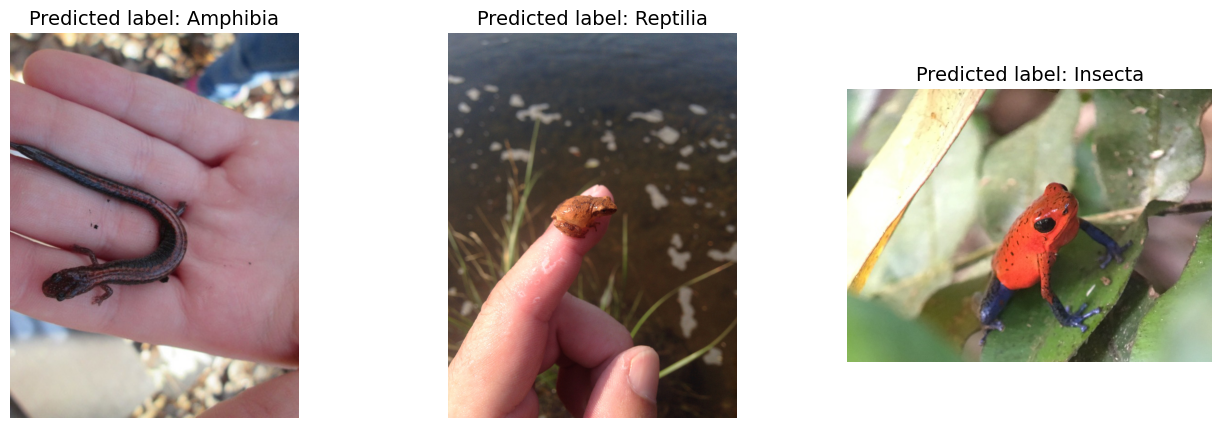




True Label :Animalia



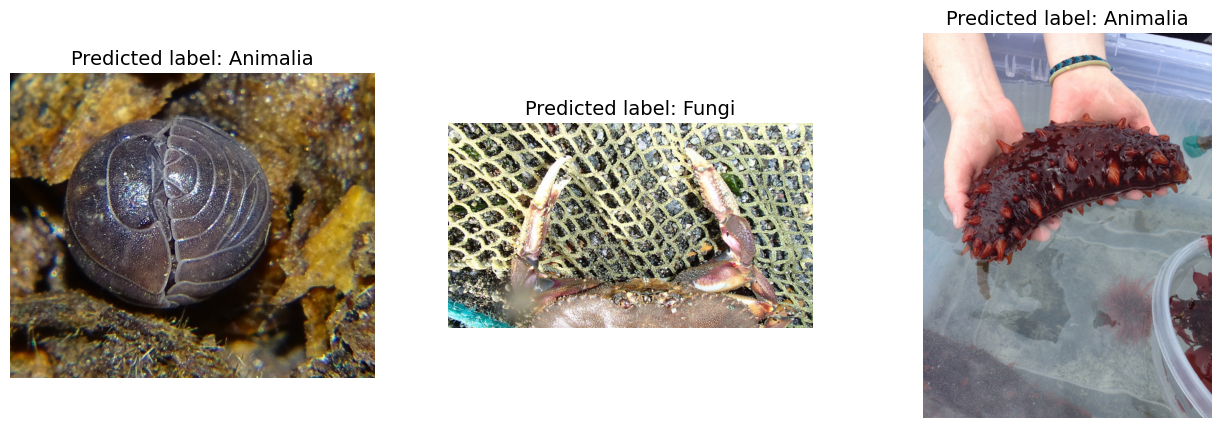




True Label :Arachnida



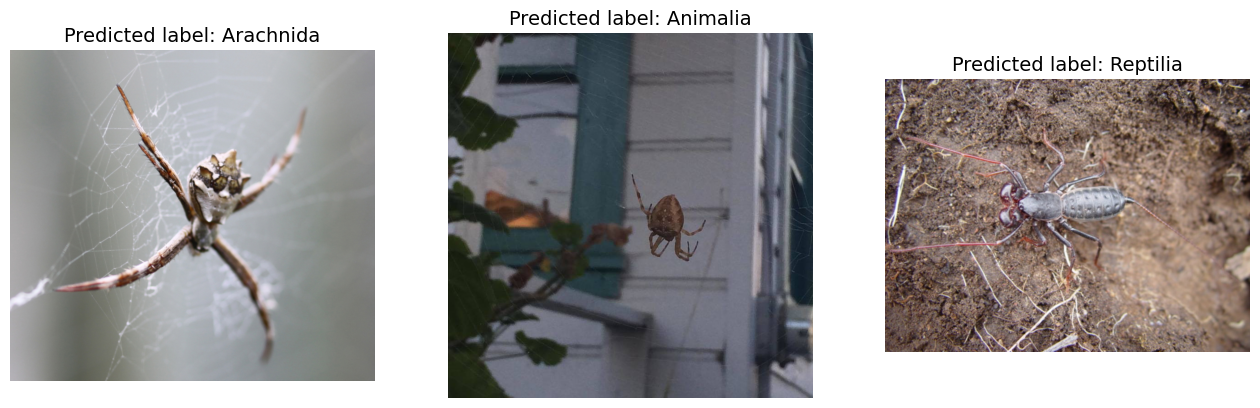




True Label :Aves



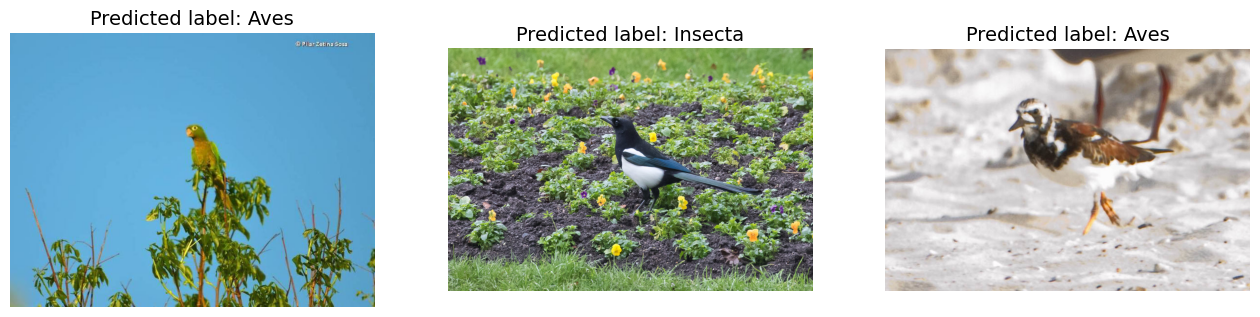




True Label :Fungi



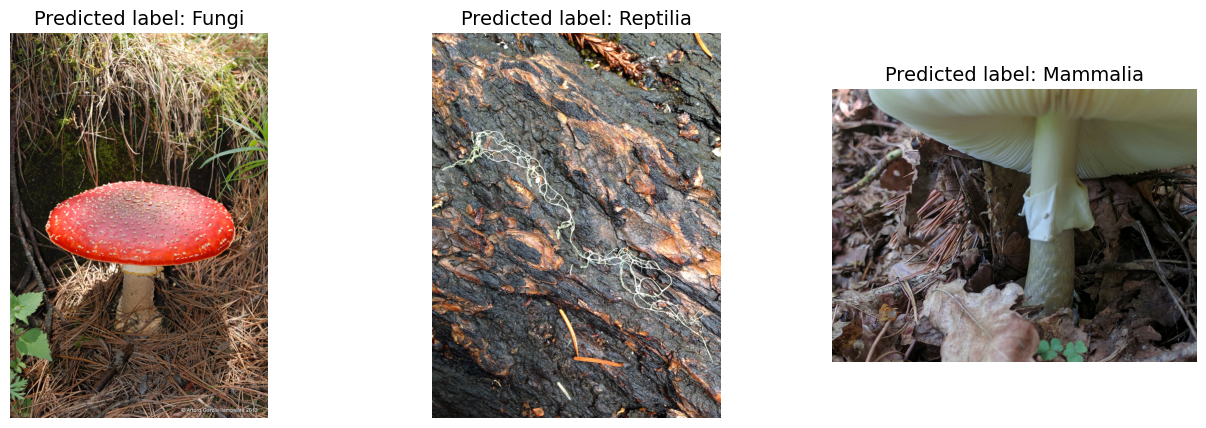




True Label :Insecta



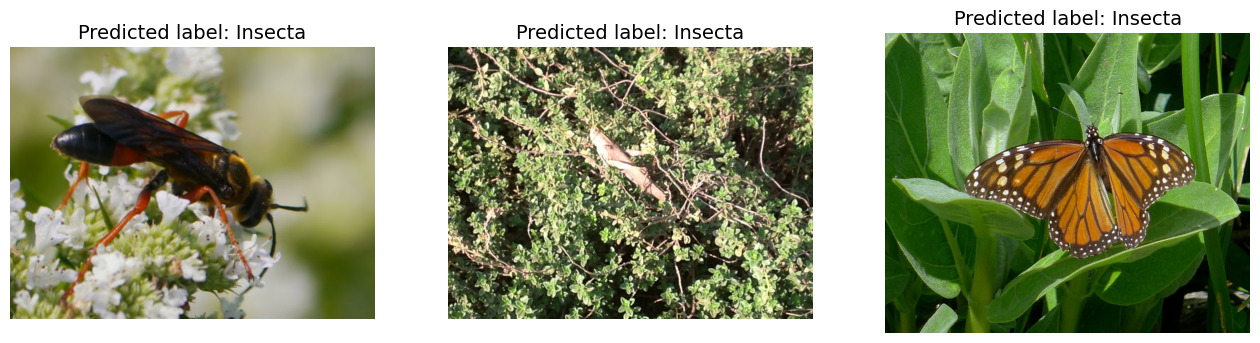




True Label :Mammalia



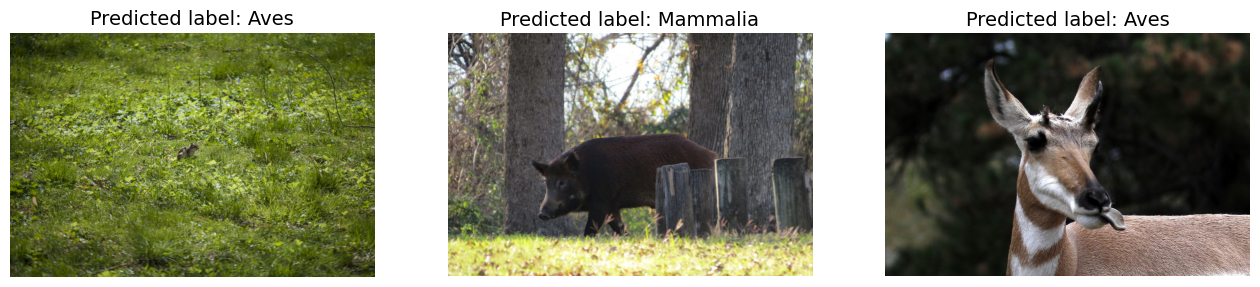




True Label :Mollusca



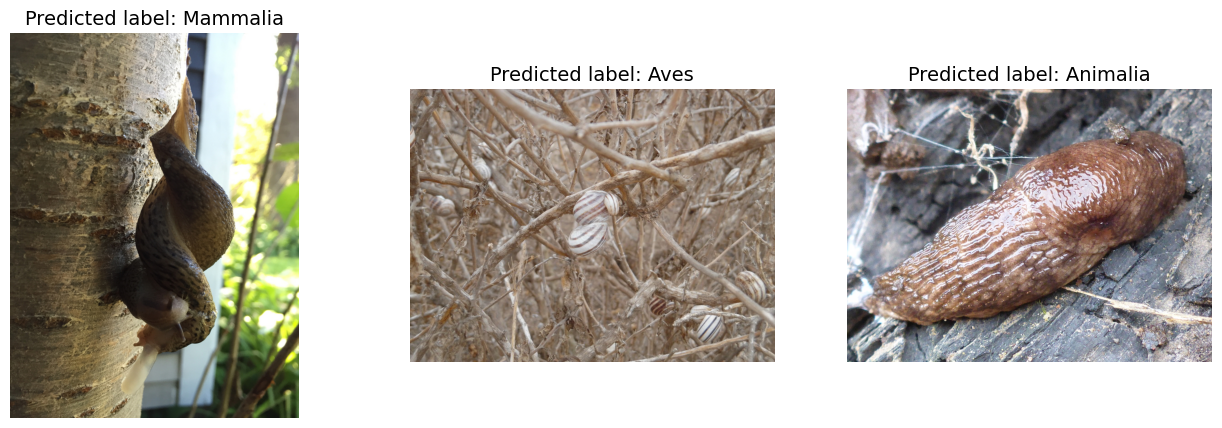




True Label :Plantae



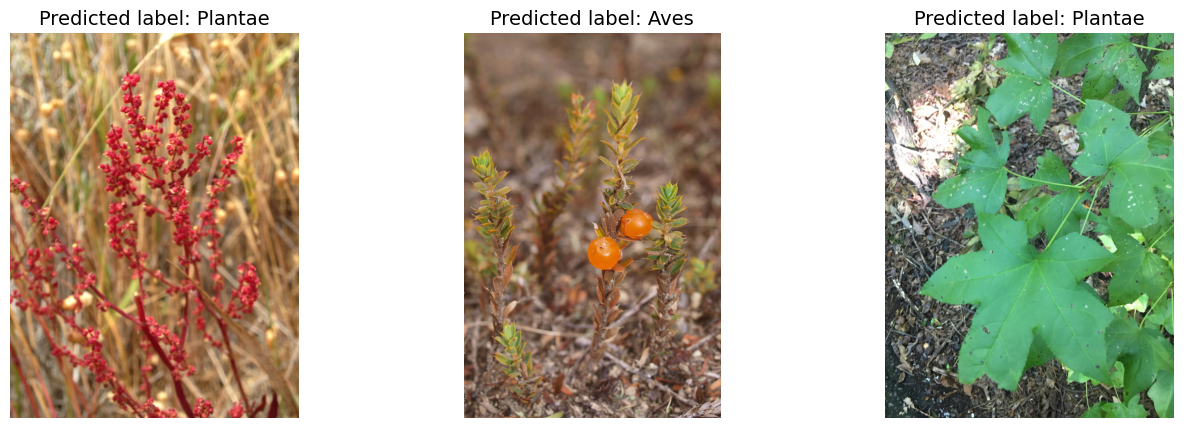




True Label :Reptilia



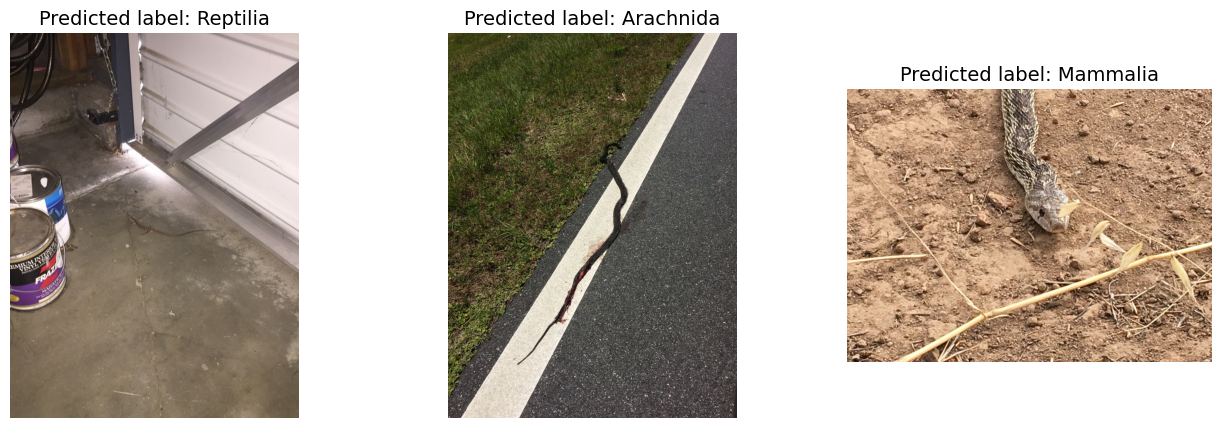

In [52]:
from PIL import Image 

test_transforms = transforms.Compose([
  transforms.Resize((128,128)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

labels = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
wandb.init(project="CS6910-Assignment-2", entity="purvam", magic=True)

for class_name in labels:
    num_test_images = len(os.listdir("/content/drive/MyDrive/CS6910/inaturalist_12K/val/"+class_name))
    test_images = os.listdir("/content/drive/MyDrive/CS6910/inaturalist_12K/val/"+class_name)
    random_indices = np.random.randint(0, num_test_images, 3)
    print(f"\n\n\nTrue Label :{class_name}\n")

    plt.figure(figsize=(16, 5))
    for i, ind in enumerate(random_indices):

        image = Image.open("/content/drive/MyDrive/CS6910/inaturalist_12K/val/"+class_name+"/"+test_images[ind])
        # Resize input image to the model input shape
        input_image = test_transforms(image)
        input_image = input_image.view(1, 3, 128, 128).cuda()
        # Predict the class
        with torch.no_grad():
          model.eval()
          out = model(input_image)
        
        prob, preds  = torch.max(out, dim=1)
  
        # Convert the index to the class label

        predicted_class = labels[preds[0].item()]
        plt.subplot(1, 3, i+1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Predicted label: {predicted_class}", size=14)

    wandb.log({f"True Label: {class_name}": plt})
    plt.show()